In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
import cv2
import random
import time
#import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import sklearn
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

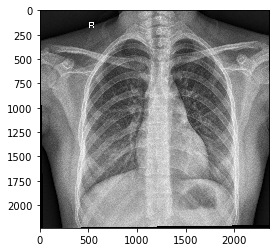

In [2]:
DATADIR = "Data"
CATEGORIES = ["NORMAL", "PNEUMONIA"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,'train/', category)
    for img in os.listdir(path):  # Iterate over every image
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) # Convert to array
        plt.imshow(img_array, cmap='gray')
        plt.show()
        # Check to see one image
        break
    break

### Import Dataset

In [3]:
# Create data set
IMG_SIZE = 150

def create_data_set(folder, container):
    for category in CATEGORIES:
        path = os.path.join(DATADIR, folder, category)
        label = CATEGORIES.index(category) # Give label: Pneumonia=1, Normal=0
        for img in os.listdir(path):  # Iterate over every image
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # Convert to array
            resized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            container.append([resized_img, label])

training_set = []
create_data_set('train/', training_set)
create_data_set('val/', training_set)
test_set = []
create_data_set('test/', test_set)

In [4]:
training_set, valid_set = train_test_split(training_set, test_size=0.2, random_state=123)
print('Training set size', len(training_set))
print('Validating set size', len(valid_set))
print('Test set size', len(test_set)) # Around 10% of data used for testing

Training set size 4185
Validating set size 1047
Test set size 624


### Shuffle Data

In [5]:
random.shuffle(training_set)
random.shuffle(test_set)

### Prepare Data for Training & Testing

In [6]:
X = []
y = []
for features, label in training_set:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)
X=X/255

X_valid = []
y_valid = []
for features, label in valid_set:
    X_valid.append(features)
    y_valid.append(label)
X_valid = np.array(X_valid).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_valid = np.array(y_valid)
X_valid=X_valid/255

X_test = []
y_test = []
for features, label in test_set:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)
X_test=X_test/255

# Account for imbalance
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

print('Class weights:', class_weights)

Class weights: [1.91270567 0.67696538]


### Augment data

In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X)

### Building Models

In [48]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=3, verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
CALLBACKS = [lr_reduce, early_stopping_cb]
METRICS = ['accuracy',
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')]

In [49]:
model_types = ['cnn-bal-aug','cnn-bal']
dense_layers = [0,1,2]
conv_layers = [1,2,3,4]
node_counts = [16,32,64,128]
for dense_layer in dense_layers:
    for conv_layer in conv_layers:
        for node_count in node_counts:
            name = model_type+"-D{}-C{}-N{}".format(dense_layer, conv_layer, node_count)
            #print(name)

In [50]:

'''
for model_type in model_types:
    for dense_layer in dense_layers:
        for conv_layer in conv_layers:
            for node_count in node_counts:
                name = "cnn-bal-aug-D{}-C{}-N{}".format(dense_layer, conv_layer, node_count)
                print('Training:', name)
                model = Sequential()
                model.add(Conv2D(node_count, (3,3), input_shape=X.shape[1:], activation='relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                for l in range(conv_layer-1):
                    model.add(Conv2D(node_count, (3,3), activation='relu'))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Flatten())
                for d in range(dense_layer):
                    model.add(Dense(node_count, activation='relu'))
                model.add(Dense(1, activation='sigmoid'))
                model.compile(loss='binary_crossentropy',
                              optimizer='adam',
                              metrics=METRICS)

                history = model.fit(datagen.flow(X,y, batch_size = 32),
                          epochs=25,
                          validation_data = (X_valid, y_valid),
                          callbacks = CALLBACKS,
                          class_weight=class_weights,
                          )

                model.save(name+'.h5')
'''

'\nfor model_type in model_types:\n    for dense_layer in dense_layers:\n        for conv_layer in conv_layers:\n            for node_count in node_counts:\n                name = "cnn-bal-aug-D{}-C{}-N{}".format(dense_layer, conv_layer, node_count)\n                print(\'Training:\', name)\n                model = Sequential()\n                model.add(Conv2D(node_count, (3,3), input_shape=X.shape[1:], activation=\'relu\'))\n                model.add(MaxPooling2D(pool_size=(2, 2)))\n                for l in range(conv_layer-1):\n                    model.add(Conv2D(node_count, (3,3), activation=\'relu\'))\n                    model.add(MaxPooling2D(pool_size=(2, 2)))\n                model.add(Flatten())\n                for d in range(dense_layer):\n                    model.add(Dense(node_count, activation=\'relu\'))\n                model.add(Dense(1, activation=\'sigmoid\'))\n                model.compile(loss=\'binary_crossentropy\',\n                              optimizer=\'

Models were trained on kaggle notebook

### Evaluate Models

In [23]:
os.chdir('models/grid_search/')

FileNotFoundError: [Errno 2] No such file or directory: 'models/grid_search/'

In [51]:
result = {}
model_name = []
valid_acc = []
valid_f1 = []
accuracy = []
precision = []
recall = []
F1_score = []
AUC = []
img_size = []

for model_type in model_types:
    for dense_layer in dense_layers:
        for conv_layer in conv_layers:
            for node_count in node_counts:
                name = model_type+"-D{}-C{}-N{}".format(dense_layer, conv_layer, node_count)
                if os.path.exists(name+'.h5'):
                    print('Testing:', name)
                    model = Sequential()
                    model.add(Conv2D(node_count, (3,3), input_shape=X.shape[1:], activation='relu'))
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                    for l in range(conv_layer-1):
                        model.add(Conv2D(node_count, (3,3), activation='relu'))
                        model.add(MaxPooling2D(pool_size=(2, 2)))
                    model.add(Flatten())
                    for d in range(dense_layer):
                        model.add(Dense(node_count, activation='relu'))
                    model.add(Dense(1, activation='sigmoid'))
                    model.compile(loss='binary_crossentropy',
                                  optimizer='adam',
                                  metrics=['accuracy'])

                    model.load_weights(name+'.h5')
                    
                    '''
                    y_pred_valid = model.predict(X_valid)
                    y_pred_valid = np.round(y_valid).astype(int)
                    valid_acc.append(metrics.accuracy_score(y_valid, y_pred_valid))
                    valid_f1.append(metrics.f1_score(y_valid, y_pred_valid))
                    '''
                    
                    y_pred = model.predict(X_test)
                    y_pred = np.round(y_pred).astype(int)
                    
                    model_name.append(name)
                    accuracy.append(metrics.accuracy_score(y_test, y_pred))
                    precision.append(metrics.precision_score(y_test, y_pred))
                    recall.append(metrics.recall_score(y_test, y_pred))
                    F1_score.append(metrics.f1_score(y_test, y_pred))
                    AUC.append(metrics.roc_auc_score(y_test, y_pred))
                    img_size.append(str(IMG_SIZE)+'X'+str(IMG_SIZE))              
                    '''
                    print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
                    print('Precision:', metrics.precision_score(y_test, y_pred))
                    print('Recall:', metrics.recall_score(y_test, y_pred))
                    print('F1:', metrics.f1_score(y_test, y_pred))
                    print('AUC:', metrics.roc_auc_score(y_test, y_pred), '\n')
                    '''
print('\nFinshed running')

Testing: cnn-bal-aug-D0-C1-N64
Testing: cnn-bal-aug-D0-C2-N64
Testing: cnn-bal-aug-D1-C2-N64
Testing: cnn-bal-aug-D1-C2-N128
Testing: cnn-bal-aug-D1-C3-N64
Testing: cnn-bal-aug-D1-C3-N128
Testing: cnn-bal-aug-D1-C4-N64
Testing: cnn-bal-aug-D1-C4-N128
Testing: cnn-bal-aug-D2-C2-N64
Testing: cnn-bal-aug-D2-C2-N128
Testing: cnn-bal-aug-D2-C3-N64
Testing: cnn-bal-aug-D2-C3-N128
Testing: cnn-bal-aug-D2-C4-N64
Testing: cnn-bal-aug-D2-C4-N128
Testing: cnn-bal-D0-C1-N16
Testing: cnn-bal-D0-C1-N32
Testing: cnn-bal-D0-C1-N64
Testing: cnn-bal-D0-C2-N16
Testing: cnn-bal-D0-C2-N32
Testing: cnn-bal-D0-C2-N64
Testing: cnn-bal-D1-C1-N16
Testing: cnn-bal-D1-C1-N32
Testing: cnn-bal-D1-C1-N64
Testing: cnn-bal-D1-C1-N128
Testing: cnn-bal-D1-C2-N16
Testing: cnn-bal-D1-C2-N32
Testing: cnn-bal-D1-C2-N64
Testing: cnn-bal-D1-C2-N128
Testing: cnn-bal-D1-C3-N32
Testing: cnn-bal-D1-C3-N64
Testing: cnn-bal-D1-C3-N128

Finshed running


In [54]:
# Visualize in dataframe
result['Model'] = model_name
#result['Validation Acc'] = valid_acc
#result['Validation F1'] = valid_f1
result['Accuracy'] = accuracy
result['Precision'] = precision
result['Recall'] = recall
result['F1 score'] = F1_score
result['AUC'] = AUC
result['Image Size'] = img_size
result = pd.DataFrame(result) 
result.head()

,Model,Accuracy,Precision,Recall,F1 score,AUC,Image Size
0,cnn-bal-aug-D0-C1-N64,0.842949,0.810638,0.976923,0.886047,0.798291,150X150
1,cnn-bal-aug-D0-C2-N64,0.778846,0.742308,0.989744,0.848352,0.708547,150X150
2,cnn-bal-aug-D1-C2-N64,0.825321,0.787321,0.987179,0.875995,0.771368,150X150
3,cnn-bal-aug-D1-C2-N128,0.814103,0.774000,0.992308,0.869663,0.754701,150X150
4,cnn-bal-aug-D1-C3-N64,0.866987,0.840355,0.971795,0.901308,0.832051,150X150


In [53]:
#result.to_csv('model_results.csv', index=False)